In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import json
import datetime

In [4]:
pd.set_option('display.max_columns', 500)

####See website http://beneathdata.com/how-to/visualizing-my-location-history/

####These maps should be redone with the cleaned_before_modeling data, so that I remove outliers, missing values for neighborhood, etc.

In [2]:
df = pd.read_pickle('df_1to7499_features.pkl')

In [5]:
df.head(2)

,OBJECTID,WOKEY,LOCATION,ADDRDESC,INITDT_dt,FLDSTARTDT_dt,FLDENDDT_dt,DURATION,DURATION_td,latitude,longitude,address,Seattle_dist,Space_Needle_dist,Pike_Place_dist,Convention_Center_dist,Woodland_Park_dist,Queene_Anne_dist,INIT_Quarter,days_end_FY,INIT_month,neighborhood_label,GEOID,GEO.id,GEO.display-label,Median_Value,Margin_of_Error,SND_FEACOD,ST_CODE,SEGMENT_TY,DIVIDED_CO,VEHICLE_US
0,1,2456,Holden pl SW bt SW Kenyon Holden ...,HOLDEN PL SW BETWEEN SW HOLDEN ST AND SW KENYO...,2010-03-29 07:00:00,2010-04-06 07:00:00,2010-04-06 07:00:00,8 days,8,47.531858,-122.363186,"SW Kenyon St, Seattle, WA, USA",5.338641,6.158729,5.467939,5.688451,9.453253,7.300465,1,3,3,93,530330114011,1500000US530330114011,"Block Group 1, Census Tract 114.01, King Count...",307500,53269,1,0,1,1,1
1,2,2514,"NE Pacific Street, one block west of Montlake ...",MONTLAKE BLVD NE AND NE PACIFIC ST ...,2010-03-30 07:00:00,2010-04-01 07:00:00,2010-04-01 07:00:00,2 days,2,47.649014,-122.304655,"Montlake Blvd NE & NE Pacific St, Seattle, WA ...",3.222458,2.867154,3.231487,2.889531,2.654837,2.610214,1,3,3,42,530330053022,1500000US530330053022,"Block Group 2, Census Tract 53.02, King County...",NaN,NaN,5,0,1,1,1


####For shapefiles I downloaded ArcGIS shapefiles from: http://www.seattle.gov/dpd/cityplanning/populationdemographics/geographicfilesmaps/2010census/default.htm

####Next I tried https://data.seattle.gov/dataset/Neighborhoods/2mbt-aqqx

In [6]:
shapefilename = 'data/Neighborhoods'
shp = fiona.open(shapefilename+'.shp')
coords = shp.bounds
shp.close()

In [7]:
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01

In [8]:
coords[0], coords[2]

(-122.43595589761988, -122.23604445458412)

In [9]:
coords[1], coords[3]

(47.49551362397606, 47.73416494684497)

In [10]:
w, h

(0.19991144303575936, 0.2386513228689111)

In [11]:
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([coords[0], coords[2]]),
    lat_0=np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)

_out = m.readshapefile(shapefilename, name='seattle', drawbounds=False, color='none', zorder=2)

In [13]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(hood_points) for hood_points in m.seattle],
    'name': [hood['S_HOOD'] for hood in m.seattle_info]
})

In [14]:
df_map.head()

,name,poly
0,OOO,"POLYGON ((12338.19322904486 22466.72127820574,..."
1,OOO,"POLYGON ((11322.23854830379 16906.90311193793,..."
2,OOO,"POLYGON ((3229.497971597746 19120.87266739659,..."
3,OOO,"POLYGON ((3002.014374016682 19226.97182663195,..."
4,OOO,"POLYGON ((11249.88175412699 18137.97426609295,..."


In [15]:
df_map.shape #121 neighborhoods

(121, 2)

In [16]:
# Convert our latitude and longitude into Basemap cartesian map coordinates
mapped_points = [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df['longitude'], 
            df['latitude'])]
all_points = MultiPoint(mapped_points)

In [17]:
# Use prep to optimize polygons for faster computation
hood_polygons = prep(MultiPolygon(list(df_map['poly'].values)))

In [18]:
# Filter out the points that do not fall within the map we're making
city_points = filter(hood_polygons.contains, all_points)

In [19]:
len(city_points), type(hood_polygons) #We've only apparently lost 25 points out of 757

(4585, shapely.prepared.PreparedGeometry)

In [20]:
city_points[0].x, city_points[0].y #Basemap cartesian coordinates now

(5635.628174733471, 4301.429431153179)

In [21]:
#Chloropleth: No. of potholes in a neighborhood
def num_of_contained_points(apolygon, city_points):
    return int(len(filter(prep(apolygon).contains, city_points)))

df_map['hood_count'] = df_map['poly'].apply(num_of_contained_points, args=(city_points,))

In [22]:
df_map['hood_count'].value_counts()

0      31
34      5
47      3
7       3
17      2
38      2
43      2
33      2
29      2
59      2
21      2
18      2
35      2
74      2
73      2
36      2
14      2
86      2
3       2
111     2
10      2
15      2
28      1
1       1
4       1
32      1
6       1
8       1
16      1
27      1
       ..
13      1
24      1
124     1
37      1
76      1
117     1
114     1
107     1
104     1
98      1
95      1
91      1
88      1
212     1
81      1
78      1
75      1
251     1
70      1
69      1
63      1
62      1
61      1
186     1
57      1
56      1
55      1
54      1
46      1
44      1
dtype: int64

In [23]:
df_map['hood_count'].sum() #number of potholes within city bounds

4585L

In [24]:
%matplotlib inline

C:\Users\andersrmr\Anaconda\lib\site-packages\IPython\kernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


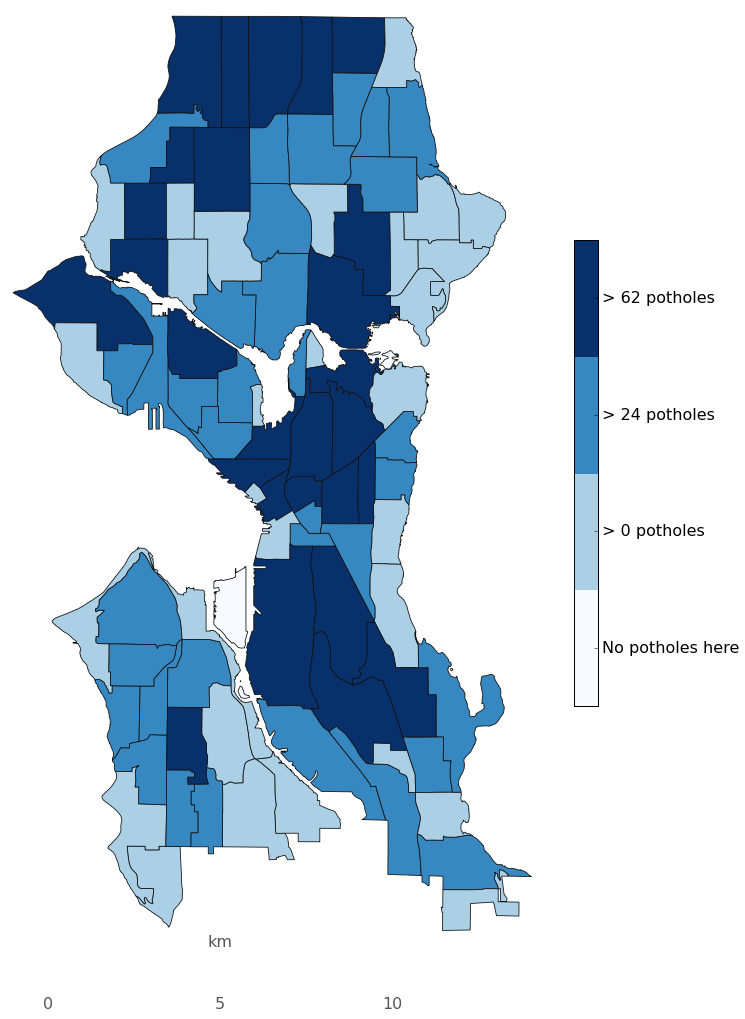

In [25]:
# Check out the full post at http://beneathdata.com/how-to/visualizing-my-location-history/
# to utilize the code below

# We'll only use a handful of distinct colors for our choropleth. So pick where
# you want your cutoffs to occur. Leave zero and ~infinity alone.
# breaks = [0.] + [2., 6., 10., 14.] + [1e20]
# def self_categorize(entry, breaks):
#     for i in range(len(breaks)-1):
#         if entry > breaks[i] and entry <= breaks[i+1]:
#             return i
#     return -1
# df_map['jenks_bins'] = df_map.hood_count.apply(self_categorize, args=(breaks,))

# jenks_labels = ['No potholes\nhere']+["> %d potholes"%(perc) for perc in breaks[:-1]]

# Or, you could always use Natural_Breaks to calculate your breaks for you:
from pysal.esda.mapclassify import Natural_Breaks
breaks = Natural_Breaks(df_map[df_map['hood_count'] > 0].hood_count, initial=300, k=3)
df_map['jenks_bins'] = -1 #default value if no data exists for this bin
df_map['jenks_bins'][df_map.hood_count > 0] = breaks.yb

jenks_labels = ['No potholes here', "> 0 potholes"]+["> %d potholes"%(perc) for perc in breaks.bins[:-1]]

def custom_colorbar(cmap, ncolors, labels, **kwargs):    
    """Create a custom, discretized colorbar with correctly formatted/aligned labels.
    
    cmap: the matplotlib colormap object you plan on using for your graph
    ncolors: (int) the number of discrete colors available
    labels: the list of labels for the colorbar. Should be the same length as ncolors.
    """
    from matplotlib.colors import BoundaryNorm
    from matplotlib.cm import ScalarMappable
        
    norm = BoundaryNorm(range(0, ncolors), cmap.N)
    mappable = ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors+1)+0.5)
    colorbar.set_ticklabels(range(0, ncolors))
    colorbar.set_ticklabels(labels)
    return colorbar

figwidth = 14
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

cmap = plt.get_cmap('Blues')
# draw neighborhoods with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#111111', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# apply our custom color values onto the patch collection
cmap_list = [cmap(val) for val in (df_map.jenks_bins.values - df_map.jenks_bins.values.min())/(
                  df_map.jenks_bins.values.max()-float(df_map.jenks_bins.values.min()))]
pc.set_facecolor(cmap_list)
ax.add_collection(pc)

#Draw a map scale
m.drawmapscale(coords[0] + 0.08, coords[1] + -0.01,
    coords[0], coords[1], 10.,
    fontsize=16, barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
    zorder=5, ax=ax,)

# ncolors+1 because we're using a "zero-th" color
cbar = custom_colorbar(cmap, ncolors=len(jenks_labels)+1, labels=jenks_labels, shrink=0.5)
cbar.ax.tick_params(labelsize=16)

# fig.suptitle("Time Spent in Seattle Neighborhoods", fontdict={'size':24, 'fontweight':'bold'}, y=0.92)
# ax.set_title("Using location data collected from my Android phone via Google Takeout", fontsize=14, y=0.98)
# ax.text(1.35, 0.04, "Collected from 2012-2014 on Android 4.2-4.4\nGeographic data provided by data.seattle.gov", 
#     ha='right', color='#555555', style='italic', transform=ax.transAxes)
# ax.text(1.35, 0.01, "BeneathData.com", color='#555555', fontsize=16, ha='right', transform=ax.transAxes)

plt.savefig('chloropleth.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')


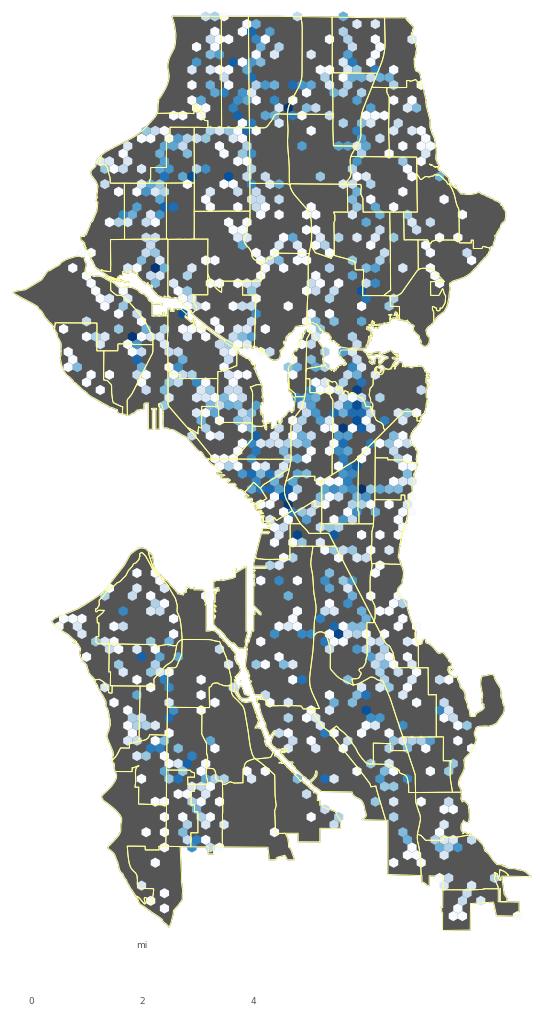

In [26]:
"""PLOT A HEXBIN MAP OF LOCATION
"""
figwidth = 14
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# draw neighborhood patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='#555555', ec='#555555', lw=1, alpha=1, zorder=0))
# plot neighborhoods by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

# the mincnt argument only shows cells with a value >= 1
# The number of hexbins you want in the x-direction
numhexbins = 50
hx = m.hexbin(
    np.array([geom.x for geom in city_points]),
    np.array([geom.y for geom in city_points]),
    gridsize=(numhexbins, int(numhexbins*h/w)), #critical to get regular hexagon, must stretch to map dimensions
    bins='log', mincnt=1, edgecolor='none', alpha=1.,
    cmap=plt.get_cmap('Blues'))

# Draw the patches again, but this time just their borders (to achieve borders over the hexbins)
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='none', ec='#FFFF99', lw=1, alpha=1, zorder=1))
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

# Draw a map scale
m.drawmapscale(coords[0] + 0.05, coords[1] - 0.01,
    coords[0], coords[1], 4.,
    units='mi', barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
    zorder=5)

# fig.suptitle("My location density in Seattle", fontdict={'size':24, 'fontweight':'bold'}, y=0.92)
# ax.set_title("Using location data collected from my Android phone via Google Takeout", fontsize=14, y=0.98)
# ax.text(1.0, 0.03, "Collected from 2012-2014 on Android 4.2-4.4\nGeographic data provided by data.seattle.gov", 
#         ha='right', color='#555555', style='italic', transform=ax.transAxes)
# ax.text(1.0, 0.01, "BeneathData.com", color='#555555', fontsize=16, ha='right', transform=ax.transAxes)
plt.savefig('hexbin.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#DEDEDE')

In [27]:
df_map['jenks_bins'].value_counts()

 1    34
-1    31
 0    29
 2    27
dtype: int64

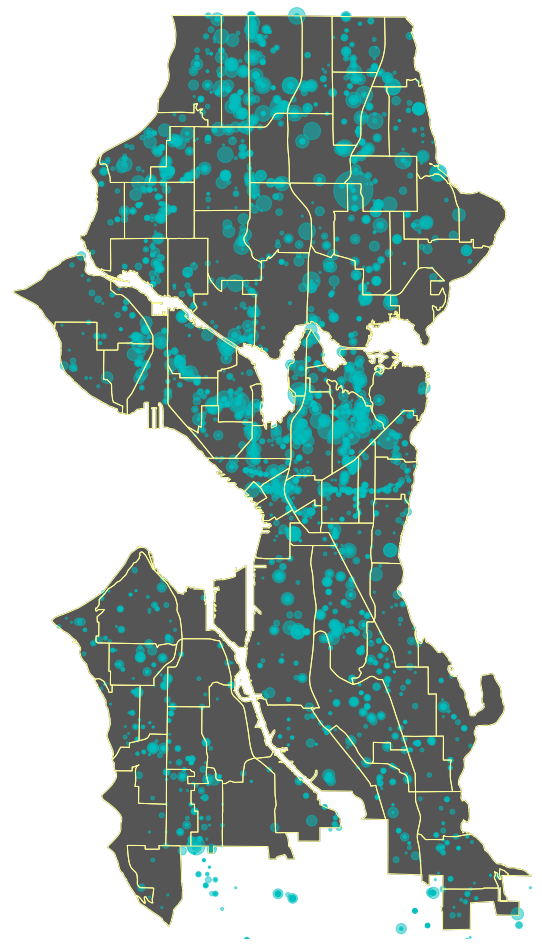

In [30]:
'''Bubble plot of pothole repair times
'''
figwidth = 14
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# draw neighborhood patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='#555555', ec='#555555', lw=1, alpha=1, zorder=0))

# plot neighborhoods by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

sizes = [x*5 for x in df['DURATION_td'].tolist()]
# Convert our latitude and longitude into Basemap cartesian map coordinates
xcart, ycart = m(df['longitude'].tolist(), df['latitude'].tolist()) #translates from lat-longs to x, y coords
m.scatter(xcart, ycart, s=sizes, marker='o',color='c', alpha=0.5)

# Draw the patches again, but this time just their borders (to achieve borders over the hexbins)
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='none', ec='#FFFF99', lw=1, alpha=1, zorder=1))
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

plt.savefig('bubble.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#DEDEDE')




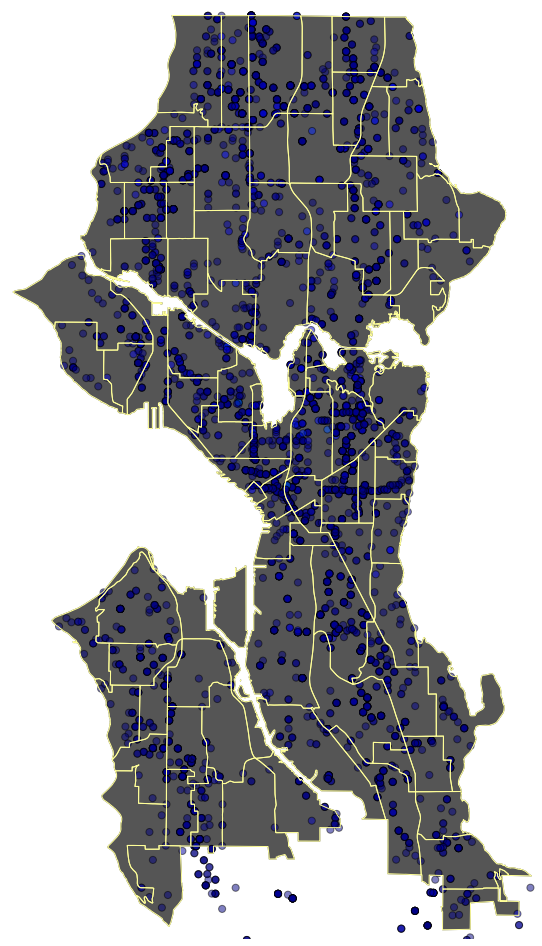

In [36]:
'''Bubble plot of pothole repair times
'''
figwidth = 14
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# draw neighborhood patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='#555555', ec='#555555', lw=1, alpha=1, zorder=0))

# plot neighborhoods by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

sizes = [5*x**1.1 for x in df['DURATION_td'].tolist()]
# Convert our latitude and longitude into Basemap cartesian map coordinates
xcart, ycart = m(df['longitude'].tolist(), df['latitude'].tolist()) #translates from lat-longs to x, y coords
m.scatter(xcart, ycart, marker='o',c=sizes, s=50, alpha=0.5)

# Draw the patches again, but this time just their borders (to achieve borders over the hexbins)
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='none', ec='#FFFF99', lw=1, alpha=1, zorder=1))
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

plt.savefig('bubble_color.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#DEDEDE')


